## Implementation of CNN from Scratch Using Numpy

**Mount Google Drive and Set Current Directory to DLA4**

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/DLA4

Mounted at /content/drive
/content/drive/MyDrive/DLA4


**Import Useful Libraries**

In [2]:

import numpy as np
import pickle
import matplotlib.pyplot as plt
from math import sqrt, ceil
import cv2
from timeit import default_timer as timer


# Forward Passes

In [3]:
def cnn_forward_pass(x, w, b, cnn_params):
    stride = cnn_params['stride']
    pad = cnn_params['pad']
    N, C, H, W = x.shape
    F, _, HH, WW = w.shape
    cache = (x, w, b, cnn_params)
    x_padded = np.pad(x, ((0, 0), (0, 0), (pad, pad), (pad, pad)), mode='constant', constant_values=0)

    height_out = int(1 + (H + 2 * pad - HH) / stride)
    width_out = int(1 + (W + 2 * pad - WW) / stride)
    feature_maps = np.zeros((N, F, height_out, width_out))

    for n in range(N):
        for f in range(F):
            height_index = 0
            for i in range(0, H, stride):
                width_index = 0
                for j in range(0, W, stride):
                    feature_maps[n, f, height_index, width_index] = \
                        np.sum(x_padded[n, :, i:i+HH, j:j+WW] * w[f, :, :, :]) + b[f]
                    width_index += 1
                height_index += 1

    return feature_maps, cache


# Testing Forward Pass for Convolutional Layer

In [4]:

def absolute_error(x, y):
    return np.sum(np.abs(x - y))

x_shape = (1, 3, 4, 4)  
w_shape = (3, 3, 4, 4)  
b_shape = (3, )

x = np.linspace(0, 255, num=np.prod(x_shape), dtype='uint8').reshape(x_shape)
w = np.linspace(-1.0, 1.0, num=np.prod(w_shape), dtype='float64').reshape(w_shape)
b = np.linspace(-1.0, 1.0, num=np.prod(b_shape), dtype='float64').reshape(b_shape)

cnn_params = {'stride': 2, 'pad': 1}

out, _ = cnn_forward_pass(x, w, b, cnn_params)


print(out.shape)  
print()
print(out)
correct_out = np.array([[[[-1577.82517483, -1715.03496503],
   [-2154.29370629, -2308.0979021 ]],

  [[  480.12587413,   440.25874126],
   [  296.38461538,   240.59440559]],

  [[ 2538.07692308,  2595.55244755],
   [ 2747.06293706,  2789.28671329]]]])

print()
print(absolute_error(correct_out, out))  


(1, 3, 2, 2)

[[[[-1577.82517483 -1715.03496503]
   [-2154.29370629 -2308.0979021 ]]

  [[  480.12587413   440.25874126]
   [  296.38461538   240.59440559]]

  [[ 2538.07692308  2595.55244755]
   [ 2747.06293706  2789.28671329]]]]

4.1748563717192155e-08


# Backward Pass for Convolutional Layer

In [5]:

def cnn_backward_pass(derivative_out, cache):
    x, w, b, cnn_params = cache
    N, C, H, W = x.shape  
    F, _, HH, WW = w.shape  
    _, _, height_out, weight_out = derivative_out.shape  
    stride = cnn_params['stride']
    pad = cnn_params['pad']
    dx = np.zeros_like(x)
    dw = np.zeros_like(w)
    db = np.zeros_like(b)
    x_padded = np.pad(x, ((0, 0), (0, 0), (pad, pad), (pad, pad)), mode='constant', constant_values=0)
    dx_padded = np.pad(dx, ((0, 0), (0, 0), (pad, pad), (pad, pad)), mode='constant', constant_values=0)

    for n in range(N):
        for f in range(F):
            for i in range(0, H, stride):
                for j in range(0, W, stride):
                    dx_padded[n, :, i:i+HH, j:j+WW] += w[f, :, :, :] * derivative_out[n, f, i, j]
                    dw[f, :, :, :] += x_padded[n, :, i:i+HH, j:j+WW] * derivative_out[n, f, i, j]
                    db[f] += derivative_out[n, f, i, j]

    dx = dx_padded[:, :, 1:-1, 1:-1]
    return dx, dw, db


# Forward Pass for Max Pooling Layer

In [6]:
def max_pooling_forward_pass(x, pooling_params):
    N, F, H, W = x.shape  

    pooling_height = pooling_params['pooling_height']
    pooling_width = pooling_params['pooling_width']
    stride = pooling_params['stride']


    cache = (x, pooling_params)


    height_pooled_out = int(1 + (H - pooling_height) / stride)
    width_polled_out = int(1 + (W - pooling_width) / stride)


    pooled_output = np.zeros((N, F, height_pooled_out, width_polled_out))


    for n in range(N):
        for i in range(height_pooled_out):
            for j in range(width_polled_out):
                ii = i * stride
                jj = j * stride
                current_pooling_region = x[n, :, ii:ii+pooling_height, jj:jj+pooling_width]
                pooled_output[n, :, i, j] = \
                    np.max(current_pooling_region.reshape((F, pooling_height * pooling_width)), axis=1)

    return pooled_output, cache


# Testing Forward Pass for Max Pooling Layer

In [7]:

def absolute_error(x, y):
    return np.sum(np.abs(x - y))



x_shape = (2, 1, 4, 4)  


x = np.linspace(0, 255, num=np.prod(x_shape), dtype='float64').reshape(x_shape)


pooling_params = {'pooling_height': 2, 'pooling_width': 2, 'stride': 2}


out, _ = max_pooling_forward_pass(x, pooling_params)


print(out.shape)  
print()
print(out)

correct_out = np.array([[[[ 41.12903226,  57.58064516],
   [106.93548387, 123.38709677]]],

 [[[172.74193548, 189.19354839],
   [238.5483871,  255.        ]]]])

print()
print(absolute_error(correct_out, out))  


(2, 1, 2, 2)

[[[[ 41.12903226  57.58064516]
   [106.93548387 123.38709677]]]


 [[[172.74193548 189.19354839]
   [238.5483871  255.        ]]]]

1.8387098066341423e-08


# Backward Pass for MAX Pooling Layer

In [8]:


def max_pooling_backward_pass(derivatives_out, cache):
    x, pooling_params = cache
    N, F, H, W = x.shape

    pooling_height = pooling_params['pooling_height']
    pooling_width = pooling_params['pooling_width']
    stride = pooling_params['stride']
    height_pooled_out = int(1 + (H - pooling_height) / stride)
    width_polled_out = int(1 + (W - pooling_width) / stride)
    dx = np.zeros((N, F, H, W))

    for n in range(N):

        for f in range(F):
            for i in range(height_pooled_out):
                for j in range(width_polled_out):
                    ii = i * stride
                    jj = j * stride
                    current_pooling_region = x[n, f, ii:ii+pooling_height, jj:jj+pooling_width]
                    current_maximum = np.max(current_pooling_region)
                    temp = current_pooling_region == current_maximum
                    dx[n, f, ii:ii+pooling_height, jj:jj+pooling_width] += \
                        derivatives_out[n, f, i, j] * temp
    return dx


# Testing Backward Pass for Max Pooling Layer

In [9]:
x_shape = (1, 1, 8, 8)  
derivatives_out_shape = (1, 1, 4, 4)  

x = np.linspace(0, 255, num=np.prod(x_shape), dtype='uint8').reshape(x_shape)
derivatives_out = np.random.randn(*derivatives_out_shape)
pooling_params = {'pooling_height': 2, 'pooling_width': 2, 'stride': 2}

out, cache = max_pooling_forward_pass(x, pooling_params)
dx = max_pooling_backward_pass(derivatives_out, cache)
print(x[0, 0, 0:2, 0:2])
print()
print(dx[0, 0, 0:2, 0:2])


[[ 0  4]
 [32 36]]

[[0.         0.        ]
 [0.         0.48795906]]


#Forward Pass for Fully-Connected Layer

In [10]:

def fc_forward(x, w, b):
    cache = (x, w, b)
    N = x.shape[0]
    x_reshaped = x.reshape(N, -1)
    fc_output = np.dot(x_reshaped, w) + b
    return fc_output, cache


# Backward Pass for Fully-Connected Layer

In [11]:

def fc_backward(derivatives_out, cache):
    x, w, b = cache
    dx = np.dot(derivatives_out, w.T).reshape(x.shape)
    N = x.shape[0]
    x = x.reshape(N, -1)
    dw = np.dot(x.T, derivatives_out)
    db = np.dot(np.ones(dx.shape[0]), derivatives_out)
    return dx, dw, db


# Naive Forward Pass for ReLU activation

In [12]:

def relu_forward(x):
    cache = x
    relu_output = np.maximum(0, x)
    return relu_output, cache


# Checking Naive Forward Pass for ReLU activation

In [13]:

x_shape = (2, 9)
x = np.random.randint(-9, 9, x_shape)
result, cache = relu_forward(x)
print(cache)
print(result)


[[ 5  7 -1  2 -8 -6  8  8  2]
 [ 5  1  1  0 -4 -5 -7  7  4]]
[[5 7 0 2 0 0 8 8 2]
 [5 1 1 0 0 0 0 7 4]]


# Backward Pass for ReLU activation

In [14]:



def relu_backward(derivatives_out, cache):
    x = cache
    temp = x > 0
    dx = temp * derivatives_out
    return dx


**Adam Optimizer**

In [15]:

def adam(w, dw, config=None):

    if config is None:
        config = {}

    config.setdefault('learning_rate', 1e-3)
    config.setdefault('beta1', 0.9)
    config.setdefault('beta2', 0.999)
    config.setdefault('epsilon', 1e-8)
    config.setdefault('m', np.zeros_like(w))
    config.setdefault('v', np.zeros_like(w))
    config.setdefault('t', 0)

    config['t'] += 1
    config['m'] = config['beta1'] * config['m'] + (1 - config['beta1']) * dw
    config['v'] = config['beta2'] * config['v'] + (1 - config['beta2']) * (dw**2)

    mt = config['m'] / (1 - config['beta1']**config['t'])
    vt = config['v'] / (1 - config['beta2']**config['t'])
    next_w = w - config['learning_rate'] * mt / (np.sqrt(vt) + config['epsilon'])
    return next_w, config
 

# Testing Backward Pass for ReLU activation

In [16]:

x_shape = (2, 9)
derivatives_out_shape = (2, 9)
x = np.random.randint(-9, 9, x_shape)
derivatives_out = np.random.randint(-9, 9, derivatives_out_shape)
result, cache = relu_forward(x)
dx = relu_backward(derivatives_out, cache)


print('Input x:\n', cache)
print('\nUpstream derivatives:\n', derivatives_out)
print('\nGradient with respect to x:\n', dx)


Input x:
 [[-1  8 -8  1  3  2  4  5  7]
 [ 4  7  2  4  2  5  1 -1  4]]

Upstream derivatives:
 [[-7 -3  5  5  0 -5 -4 -2 -4]
 [-8  3 -7 -3 -4  4 -3  2  1]]

Gradient with respect to x:
 [[ 0 -3  0  5  0 -5 -4 -2 -4]
 [-8  3 -7 -3 -4  4 -3  0  1]]


# Softmax Classification Loss

In [17]:


def softmax_loss(x, y):
    # Calculating probabilities
    shifted_logits = x - np.max(x, axis=1, keepdims=True)
    z = np.sum(np.exp(shifted_logits), axis=1, keepdims=True)
    log_probabilities = shifted_logits - np.log(z)
    probabilities = np.exp(log_probabilities)

    # Getting number of samples
    N = x.shape[0]

    # Calculating Logarithmic Loss
    loss = -np.sum(log_probabilities[np.arange(N), y]) / N

    # Calculating gradient
    dx = probabilities
    dx[np.arange(N), y] -= 1
    dx /= N

    # Returning tuple of Logarithmic loss and gradient
    return loss, dx


# Creating Convolutional Neural Network Model

In [18]:




class ConvNet1(object):



    def __init__(self, input_dimension=(3, 32, 32), number_of_filters=32, size_of_filter=7,
                 hidden_dimension=100, number_of_classes=10, weight_scale=1e-3, regularization=0.0,
                 dtype=np.float32):
      
        self.params = {}

        self.regularization = regularization

        self.dtype = dtype
 
        C, H, W = input_dimension

        HH = WW = size_of_filter

        F = number_of_filters

        Hh = hidden_dimension

        Hclass = number_of_classes

        self.params['w1'] = weight_scale * np.random.rand(F, C, HH, WW)
        self.params['b1'] = np.zeros(F)



        self.cnn_params = {'stride': 1, 'pad': int((size_of_filter - 1) / 2)}
        Hc = int(1 + (H + 2 * self.cnn_params['pad'] - HH) / self.cnn_params['stride'])
        Wc = int(1 + (W + 2 * self.cnn_params['pad'] - WW) / self.cnn_params['stride'])



        self.pooling_params = {'pooling_height': 2, 'pooling_width': 2, 'stride': 2}
        Hp = int(1 + (Hc - self.pooling_params['pooling_height']) / self.pooling_params['stride'])
        Wp = int(1 + (Wc - self.pooling_params['pooling_width']) / self.pooling_params['stride'])


        self.params['w2'] = weight_scale * np.random.rand(F * Hp * Wp, Hh)
        self.params['b2'] = np.zeros(Hh)



        self.params['w3'] = weight_scale * np.random.rand(Hh, Hclass)
        self.params['b3'] = np.zeros(Hclass)


        for d_key, d_value in self.params.items():
            self.params[d_key] = d_value.astype(dtype)


    def loss_for_training(self, x, y):
        w1, b1 = self.params['w1'], self.params['b1']
        w2, b2 = self.params['w2'], self.params['b2']
        w3, b3 = self.params['w3'], self.params['b3']

        # Implementing forward pass for ConvNet1 and computing scores for every input
        # Forward pass:
        # Input --> Conv --> ReLU --> Pool --> FC --> ReLU --> FC --> Softmax
        cnn_output, cache_cnn = cnn_forward_pass(x, w1, b1, self.cnn_params)
        relu_output_1, cache_relu_1 = relu_forward(cnn_output)
        pooling_output, cache_pooling = max_pooling_forward_pass(relu_output_1, self.pooling_params)
        fc_hidden, cache_fc_hidden = fc_forward(pooling_output, w2, b2)
        relu_output_2, cache_relu_2 = relu_forward(fc_hidden)
        scores, cache_fc_output = fc_forward(relu_output_2, w3, b3)

        # Computing loss and gradients
        loss, d_scores = softmax_loss(scores, y)

        # Adding L2 regularization
        loss += 0.5 * self.regularization * np.sum(np.square(w1))
        loss += 0.5 * self.regularization * np.sum(np.square(w2))
        loss += 0.5 * self.regularization * np.sum(np.square(w3))

        # Implementing backward pass for ConvNet1
        # Backward pass through FC output
        dx3, dw3, db3 = fc_backward(d_scores, cache_fc_output)
        # Adding L2 regularization
        dw3 += self.regularization * w3

        # Backward pass through ReLU and FC Hidden
        d_relu_2 = relu_backward(dx3, cache_relu_2)
        dx2, dw2, db2 = fc_backward(d_relu_2, cache_fc_hidden)
        # Adding L2 regularization
        dw2 += self.regularization * w2

        # Backward pass through Pool, ReLU and Conv
        d_pooling = max_pooling_backward_pass(dx2, cache_pooling)
        d_relu_1 = relu_backward(d_pooling, cache_relu_1)
        dx1, dw1, db1 = cnn_backward_pass(d_relu_1, cache_cnn)
        # Adding L2 regularization
        dw1 += self.regularization * w1

        # Putting resulted derivatives into gradient dictionary
        gradients = dict()
        gradients['w1'] = dw1
        gradients['b1'] = db1
        gradients['w2'] = dw2
        gradients['b2'] = db2
        gradients['w3'] = dw3
        gradients['b3'] = db3

        # Returning loss and gradients
        return loss, gradients

    # Defining function for calculating Scores for Predicting.
    def scores_for_predicting(self, x):
        # Getting weights and biases
        w1, b1 = self.params['w1'], self.params['b1']
        w2, b2 = self.params['w2'], self.params['b2']
        w3, b3 = self.params['w3'], self.params['b3']

        # Implementing forward pass for ConvNet1 and computing scores for every input
        # Forward pass:
        # Input --> Conv --> ReLU --> Pool --> FC --> ReLU --> FC --> Softmax
        cnn_output, _ = cnn_forward_pass(x, w1, b1, self.cnn_params)
        relu_output_1, _ = relu_forward(cnn_output)
        pooling_output, _ = max_pooling_forward_pass(relu_output_1, self.pooling_params)
        affine_hidden, _ = fc_forward(pooling_output, w2, b2)
        relu_output_2, _ = relu_forward(affine_hidden)
        scores, _ = fc_forward(relu_output_2, w3, b3)

        # Returning scores for every input
        return scores


# Initializing new Model and checking dimensions of weights for every Layer

In [19]:

model = ConvNet1(hidden_dimension=500)

N = 5
x = np.random.randn(N, 3, 32, 32)  
y = np.random.randint(10, size=N)  


loss, gradients = model.loss_for_training(x, y)


for param_name in model.params:
    print(param_name, model.params[param_name].shape)  
    print(param_name, gradients[param_name].shape)  
    print()


w1 (32, 3, 7, 7)
w1 (32, 3, 7, 7)

b1 (32,)
b1 (32,)

w2 (8192, 500)
w2 (8192, 500)

b2 (500,)
b2 (500,)

w3 (500, 10)
w3 (500, 10)

b3 (10,)
b3 (10,)



**MNIST CLASSIFICATION**

In [20]:



# Creating class for training
class Train(object):


    def __init__(self, model, data, **kwargs):
        # Preparing required arguments
        self.model = model
        self.x_train = data['x_train']
        self.y_train = data['y_train']
        self.x_validation = data['x_validation']
        self.y_validation = data['y_validation']

        self.optimization_config = kwargs.pop('optimization_config', {})  # Default is '{}'
        self.learning_rate_decay = kwargs.pop('learning_rate_decay', 1.0)  # Default is '1.0'
        self.batch_size = kwargs.pop('batch_size', 100)  # Default is '100'
        self.number_of_epochs = kwargs.pop('number_of_epochs', 10)  # Default is '10'
        self.print_every = kwargs.pop('print_every', 10)  # Default is '10'
        self.verbose_mode = kwargs.pop('verbose_mode', True)  # Default is 'True'

 
        if len(kwargs) > 0:
            extra = ', '.join(k for k in kwargs.keys())
            raise ValueError('Extra argument:', extra)

        self.update_rule = adam


        self._reset()

    # Creating 'reset' function for defining variables for optimization
    def _reset(self):
        # Setting up variables
        self.current_epoch = 0
        self.best_validation_accuracy = 0
        self.best_params = {}
        self.loss_history = []
        self.train_accuracy_history = []
        self.validation_accuracy_history = []

        self.optimization_configurations = {}
        for p in self.model.params:
            d = {k: v for k, v in self.optimization_config.items()}
            self.optimization_configurations[p] = d

    # Creating function 'step' for making single gradient update
    def _step(self):

        number_of_training_images = self.x_train.shape[0]
        batch_mask = np.random.choice(number_of_training_images, self.batch_size)
        x_batch = self.x_train[batch_mask]
        y_batch = self.y_train[batch_mask]
        loss, gradient = self.model.loss_for_training(x_batch, y_batch)
        self.loss_history.append(loss)
        for p, v in self.model.params.items():
            dw = gradient[p]
            config_for_current_p = self.optimization_configurations[p]
            next_w, next_configuration = self.update_rule(v, dw, config_for_current_p)
            self.model.params[p] = next_w
            self.optimization_configurations[p] = next_configuration

    def check_accuracy(self, x, y, number_of_samples=None, batch_size=100):



        N = x.shape[0]

        if number_of_samples is not None and N > number_of_samples:
            batch_mask = np.random.choice(N, number_of_samples)
            N = number_of_samples
            x = x[batch_mask]
            y = y[batch_mask]

        number_of_batches = int(N / batch_size)

        if N % batch_size != 0:
            number_of_batches += 1

        y_predicted = []

        for i in range(number_of_batches):

            s = i * batch_size
            e = (i + 1) * batch_size

            scores = self.model.scores_for_predicting(x[s:e])
            y_predicted.append(np.argmax(scores, axis=1))
        y_predicted = np.hstack(y_predicted)


        accuracy = np.mean(y_predicted == y)

        return accuracy

    def run(self):
        number_of_training_images = self.x_train.shape[0]
        iterations_per_one_epoch = int(max(number_of_training_images / self.batch_size, 1))
        iterations_total = int(self.number_of_epochs * iterations_per_one_epoch)

        for t in range(iterations_total):
            self._step()

            if self.verbose_mode and t % self.print_every == 0:

                print('Iteration: ' + str(t + 1) + '/' + str(iterations_total) + ',',
                      'loss =', self.loss_history[-1])


            end_of_current_epoch = (t + 1) % iterations_per_one_epoch == 0


            if end_of_current_epoch:

                self.current_epoch += 1

                for k in self.optimization_configurations:
                    self.optimization_configurations[k]['learning_rate'] *= self.learning_rate_decay

            # Defining variables for first and last iterations
            first_iteration = (t == 0)
            last_iteration = (t == iterations_total - 1)


            if first_iteration or last_iteration or end_of_current_epoch:
  
                training_accuracy = self.check_accuracy(self.x_train, self.y_train,
                                                        number_of_samples=1000)

                validation_accuracy = self.check_accuracy(self.x_validation, self.y_validation)

                self.train_accuracy_history.append(training_accuracy)
                self.validation_accuracy_history.append(validation_accuracy)

                if self.verbose_mode:

                    print('Epoch: ' + str(self.current_epoch) + '/' + str(self.number_of_epochs) + ',',
                          'Training accuracy = ' + str(training_accuracy) + ',',
                          'Validation accuracy = ' + str(validation_accuracy))

                if validation_accuracy > self.best_validation_accuracy:
                    self.best_validation_accuracy = validation_accuracy

                    self.best_params = {}

                    for k, v in self.model.params.items():
                        self.best_params[k] = v

        self.model.params = self.best_params


        with open('model_params_ConvNet1.pickle', 'wb') as f:
            pickle.dump(self.model.params, f)

        history_dictionary = {'loss_history': self.loss_history,
                              'train_accuracy_history': self.train_accuracy_history,
                              'validation_history': self.validation_accuracy_history}
        with open('model_histories_ConvNet1.pickle', 'wb') as f:
            pickle.dump(history_dictionary, f)


In [21]:
# Opening file for reading in binary mode
with open('Data/data.pickle', 'rb') as f:
    d = pickle.load(f, encoding='latin1')  # dictionary type


for i, j in d.items():
    print(i + ':', j.shape)



y_validation: (1000,)
y_test: (1000,)
x_validation: (1000, 1, 28, 28)
x_train: (59000, 1, 28, 28)
y_train: (59000,)
x_test: (1000, 1, 28, 28)


In [ ]:

model = ConvNet1(input_dimension=(1, 28, 28), weight_scale=1e-3, hidden_dimension=500, regularization=1e-3)

# Creating instance of class for training and initializing model
train = Train(model,
                d,
                optimization_config={'learning_rate':1e-3},
                learning_rate_decay=1.0,
                batch_size=50,
                number_of_epochs=3,
                print_every=20,
                verbose_mode=True
               )

# Running training process
train.run()

In [ ]:
# Saving trained model parameters locally without commiting
from IPython.display import FileLink

FileLink('model_params_ConvNet1.pickle')


In [ ]:
# Saving loss, training accuracy and validation accuracy histories locally without commiting
from IPython.display import FileLink

FileLink('model_histories_ConvNet1.pickle')


**Plotting CNN Results**

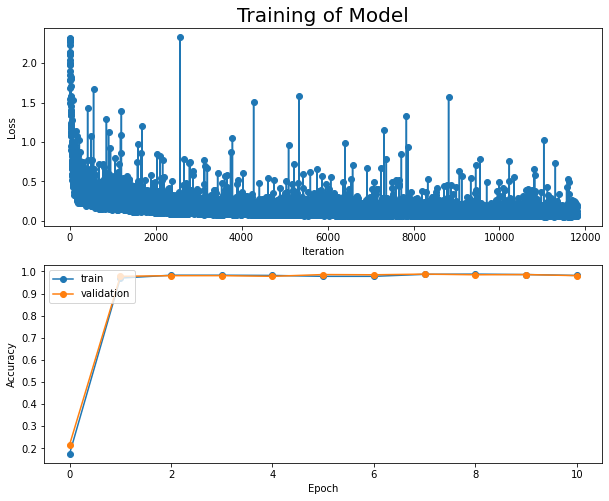

In [26]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Setting default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


# Opening file with history for reading in binary mode
with open('Data/model_histories_ConvNet1_Training.pickle', 'rb') as f:
    history_dictionary = pickle.load(f, encoding='latin1')  # dictionary type, we use 'latin1' for python3

    
# Plotting history
fig = plt.figure()
plt.subplot(2, 1, 1)
plt.plot(history_dictionary['loss_history'], '-o')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training of Model', fontsize=20)

plt.subplot(2, 1, 2)
plt.plot(history_dictionary['train_accuracy_history'], '-o')
plt.plot(history_dictionary['validation_history'], '-o')
plt.legend(['train', 'validation'], loc='upper left')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()
# Saving plot
fig.savefig('Training_Process.png')
plt.close()


w1: (32, 1, 7, 7)
b1: (32,)
w2: (6272, 500)
b2: (500,)
w3: (500, 10)
b3: (10,)

w1: (32, 1, 7, 7)
b1: (32,)
w2: (6272, 500)
b2: (500,)
w3: (500, 10)
b3: (10,)


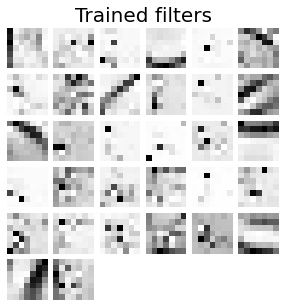

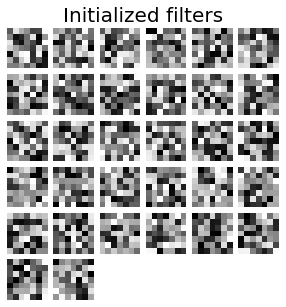

In [27]:
# Opening file for reading in binary mode
with open('Data/model_params_ConvNet1.pickle', 'rb') as f:
    d_trained = pickle.load(f, encoding='latin1')  


for i, j in d_trained.items():
    print(i + ':', j.shape)


model_1 = ConvNet1(input_dimension=(1, 28, 28))

model_1.params = d_trained

# Showing assigned parameters
print()
for i, j in model_1.params.items():
    print(i + ':', j.shape)



def convert_to_grid(x_input):
    N, H, W, C = x_input.shape
    grid_size = int(ceil(sqrt(N)))
    grid_height = H * grid_size + 1 * (grid_size - 1)
    grid_width = W * grid_size + 1 * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C)) + 255
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = x_input[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = 255.0 * (img - low) / (high - low)
                next_idx += 1
            x0 += W + 1
            x1 += W + 1
        y0 += H + 1
        y1 += H + 1

    return grid


d_trained['w1'] = d_trained['w1'].transpose(0, 2, 3, 1)
# print(d_trained['w1'].shape)  # (32, 7, 7, 1)

a = np.zeros((32, 7, 7, 3))
a[:, :, :, 0] = d_trained['w1'][:, :, :, 0]
a[:, :, :, 1] = d_trained['w1'][:, :, :, 0]
a[:, :, :, 2] = d_trained['w1'][:, :, :, 0]

# Plotting
fig = plt.figure()
grid = convert_to_grid(a)
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.title('Trained filters', fontsize=20)
plt.show()
# Saving plot
fig.savefig('Trained_filters.png')
plt.close()


model = ConvNet1(input_dimension=(1, 28, 28))


model.params['w1'] = model.params['w1'].transpose(0, 2, 3, 1)



a = np.zeros((32, 7, 7, 3))
a[:, :, :, 0] = model.params['w1'][:, :, :, 0]
a[:, :, :, 1] = model.params['w1'][:, :, :, 0]
a[:, :, :, 2] = model.params['w1'][:, :, :, 0]

# Plotting
fig = plt.figure()
grid = convert_to_grid(a)
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.title('Initialized filters', fontsize=20)
plt.show()
# Saving plot
fig.savefig('Initialized_filters.png')
plt.close()


**Predicting Images from Test Dataset**

w1: (32, 1, 7, 7)
b1: (32,)
w2: (6272, 500)
b2: (500,)
w3: (500, 10)
b3: (10,)

w1: (32, 1, 7, 7)
b1: (32,)
w2: (6272, 500)
b2: (500,)
w3: (500, 10)
b3: (10,)

True label: 7
Predicted label: 7

All scores [[ -5.70410525  -1.51485009  -5.13847175  -2.18203688 -10.75619231
   -8.08295607 -14.73187346  10.93546779  -6.1267422   -5.00792847]]


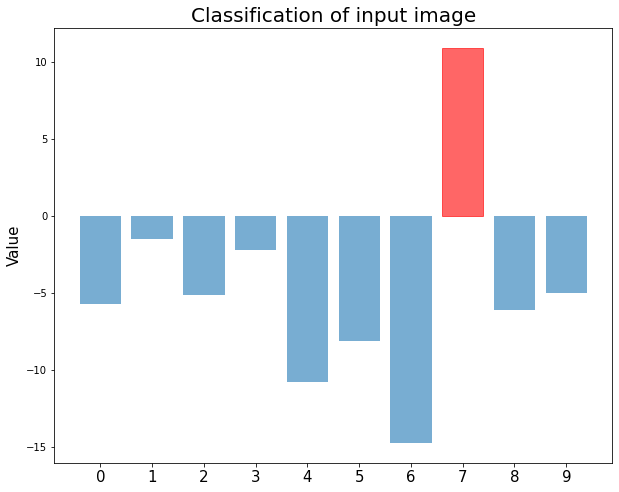

In [28]:
# Opening file for reading in binary mode
with open('Data/model_params_ConvNet1.pickle', 'rb') as f:
    d_trained = pickle.load(f, encoding='latin1')  # dictionary type, we use 'latin1' for python3

# Showing loaded data from file
for i, j in d_trained.items():
    print(i + ':', j.shape)


model_1 = ConvNet1(input_dimension=(1, 28, 28))

model_1.params = d_trained


print()
for i, j in model_1.params.items():
    print(i + ':', j.shape)



labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


# Preparing data for predicting from test dataset
x_input = d['x_test'][:1]
y_input = d['y_test'][:1]
# True label
print()
print('True label:', labels[y_input[0]])

# Getting scores from forward pass of input image
scores = model_1.scores_for_predicting(x_input)


print('Predicted label:', labels[np.argmax(scores, axis=1)[0]])


# Printing all scores
print()
print('All scores', scores)


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Setting default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Plotting scores
fig = plt.figure()
x_positions = np.arange(len(labels))
barlist = plt.bar(x_positions, scores[0], align='center', alpha=0.6)
barlist[np.argmax(scores)].set_color('red')
plt.xticks(x_positions, labels, fontsize=15)
plt.ylabel('Value', fontsize=15)
plt.title('Classification of input image', fontsize=20)

plt.show()
# Saving plot
fig.savefig('Classification_of_input_image.png')
plt.close()


**Test Moderl On User Input Image**

In [ ]:

x_input = cv2.imread('1.png', 0)

# Adding one channel to the GrayScale image
x_input = x_input.reshape(210, 210, 1)

# Getting image shape
print(x_input.shape)  # (210, 210, 1)


blob = cv2.dnn.blobFromImage(x_input, 1 / 255.0, (28, 28), swapRB=True, crop=False)

# Getting blob's shape
print(blob.shape)  # (1, 1, 32, 32)


with open('Data/model_params_ConvNet1.pickle', 'rb') as f:
    mean_and_std = pickle.load(f, encoding='latin1')  # dictionary type, we use 'latin1' for python3

# Getting mean image and std from dictionary
mean_image = mean_and_std['mean_image']
std = mean_and_std['std']

# Getting shape
print(mean_image.shape)  # (28, 28, 1)
print(std.shape)  # (28, 28, 1)


mean_image = mean_image.transpose(2, 0, 1)
std = std.transpose(2, 0, 1)

# Getting shape
print(mean_image.shape)  # (1, 28, 28)
print(std.shape)  # (1, 28, 28)
print()

# Subtracting mean image from blob
blob[0] -= mean_image
# Dividing by standard deviation
blob[0] /= std


# MNIST has 10 digits from 0 to 9
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Opening file for reading in binary mode
with open('model_params_ConvNet1.pickle', 'rb') as f:
    d_trained = pickle.load(f, encoding='latin1')  # dictionary type, we use 'latin1' for python3

# Creating instance of class and initializing model
model = ConvNet1(input_dimension=(1, 28, 28))

model.params = d_trained

# Showing assigned parameters
for i, j in model.params.items():
    print(i + ':', j.shape)
print()
    

start = timer()
scores = model.scores_for_predicting(blob)
end = timer()


print('Predicted label is', labels[np.argmax(scores, axis=1)[0]])
print('Time spent for pedicting: {} seconds'.format(round(end - start, 5)))
print()

print(scores)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # Setting default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Plotting scores
fig = plt.figure()
x_positions = np.arange(len(labels))
barlist = plt.bar(x_positions, scores[0], align='center', alpha=0.6)
barlist[np.argmax(scores)].set_color('red')
plt.xticks(x_positions, labels, fontsize=15)
plt.ylabel('Value', fontsize=15)
plt.title('Classification of user\'s image', fontsize=20)

plt.show()
# Saving plot
fig.savefig('Classification_of_users_image.png')
plt.close()



x_input = cv2.resize(x_input, (200, 200), interpolation=cv2.INTER_AREA)

# Preparing text with label and score
text = 'Label: {}'.format(labels[np.argmax(scores, axis=1)[0]])

# Preparing colour
colour = [0, 255, 0]

# Putting text with label and confidence on the original image
cv2.putText(x_input, text, (10, 25), cv2.FONT_HERSHEY_TRIPLEX, 0.8, colour, 1)

# Showing resulted image
fig = plt.figure()
plt.imshow(cv2.cvtColor(x_input, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
# Saving plot
fig.savefig('Users_image_with_label.png')
plt.close()
